# __BAX-452 Assignment 3: Regularization and Out-of-sample Analysis__

#### 001 - Yumi Jin

### __1. Data Exploration and Visualization:__

In [41]:
# load the packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.base import clone
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, BayesianRidge, LassoLarsIC, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer

In [42]:
# read in the data
house = pd.read_csv('/Users/yumi/ucdavis/Winter Quarter/BAX-452/Assignments/HW3/Melbourne_housing.csv')

#### __1.1 Explore the Melbourne house Dataset and handle missing values__

In [43]:
# display the first 5 observations
house.head(5)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Thornbury,7/67 Pender St,2,u,438000.0,SP,Love,22/08/2016,6.5,3071,...,1.0,1.0,0.0,66.0,1970.0,Darebin City Council,-37.7541,145.0088,Northern Metropolitan,8870
1,Coburg,32 Rose St,2,h,901000.0,S,Peter,27/06/2016,7.8,3058,...,1.0,1.0,545.0,107.0,1940.0,Darebin City Council,-37.7445,144.9471,Northern Metropolitan,11204
2,Bentleigh East,2/25 Brooks St,3,u,800000.0,S,Woodards,28/05/2016,13.9,3165,...,2.0,2.0,261.0,NaN,NaN,Glen Eira City Council,-37.9163,145.0779,Southern Metropolitan,10969
3,Templestowe Lower,2/35 John St,3,t,1155000.0,S,Jellis,25/11/2017,12.4,3107,...,NaN,NaN,NaN,NaN,NaN,Manningham City Council,NaN,NaN,Eastern Metropolitan,5420
4,South Yarra,1/35 Marne St,3,u,1630000.0,PI,Jellis,10/9/16,3.3,3141,...,1.0,1.0,0.0,NaN,NaN,Melbourne City Council,-37.8359,144.9839,Southern Metropolitan,14887


In [44]:
# checking for any null values 
house.isnull().sum()

Suburb             0
Address            0
Rooms              0
Type               0
Price            108
Method             0
SellerG            0
Date               0
Distance           0
Postcode           0
Bedroom2         128
Bathroom         128
Car              137
Landsize         174
BuildingArea     310
YearBuilt        287
CouncilArea        0
Lattitude        122
Longtitude       122
Regionname         0
Propertycount      0
dtype: int64

I noticed that there are many missing values in the dataset and they will be cleaned with the following actions:  
- Any row missing the 'Price' value should be __excluded__ from the dataset, as it's crucial for  the prediction model.
- Missing values in 'Bathroom', and 'Car' were imputed using the __median__.  
- Missing values in 'Landsize', 'Lattitude', and 'Longtitude' were imputed using the __mean__.  
- The columns 'BuildingArea' and 'YearBuilt' were __dropped__ due to more than 50% missing values, which makes them less reliable for predictive modeling.  
- I will drop 'bedroom2' because the rooms column is concurrent with the values present in the Bedroom2 column.
- I will also remove columns that are not useful to predict the selling price of the house. These variables include Suburb, Address, Postcode, and Date.

In [45]:
# impute missing values
imputer_median = SimpleImputer(strategy='median')
imputer_mean = SimpleImputer(strategy='mean')

# columns to impute with median
median_cols = ['Bathroom', 'Car']

# columns to impute with mean
mean_cols = ['Landsize', 'Lattitude', 'Longtitude']

# applying imputation
house[median_cols] = imputer_median.fit_transform(house[median_cols])
house[mean_cols] = imputer_mean.fit_transform(house[mean_cols])

# check if BuildingArea and YearBuilt should be dropped due to high missing values
missing_percentage = house.isnull().mean() * 100
drop_columns = missing_percentage[missing_percentage > 50].index.tolist()

# dropping columns with more than 50% missing values
house_clean = house.drop(columns=drop_columns)

# dropping rows that are not useful in predicting price
house_clean = house_clean.drop(['Suburb', 'Address',
                                'Date', 'Postcode', 'Bedroom2'], axis=1)

# dropping rows where 'Price' is missing
house_clean = house_clean.dropna(subset=['Price'])

house_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 391 entries, 0 to 497
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Rooms          391 non-null    int64  
 1   Type           391 non-null    object 
 2   Price          391 non-null    float64
 3   Method         391 non-null    object 
 4   SellerG        391 non-null    object 
 5   Distance       391 non-null    float64
 6   Bathroom       391 non-null    float64
 7   Car            391 non-null    float64
 8   Landsize       391 non-null    float64
 9   CouncilArea    391 non-null    object 
 10  Lattitude      391 non-null    float64
 11  Longtitude     391 non-null    float64
 12  Regionname     391 non-null    object 
 13  Propertycount  391 non-null    int64  
dtypes: float64(7), int64(2), object(5)
memory usage: 45.8+ KB


In [46]:
# display the summary of the data
house_clean.describe(include = 'all')

,Rooms,Type,Price,Method,SellerG,Distance,Bathroom,Car,Landsize,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
count,391.000000,391,3.910000e+02,391,391,391.000000,391.000000,391.000000,391.000000,391,391.000000,391.000000,391,391.000000
unique,NaN,3,NaN,5,85,NaN,NaN,NaN,NaN,29,NaN,NaN,8,NaN
top,NaN,h,NaN,S,Jellis,NaN,NaN,NaN,NaN,Darebin City Council,NaN,NaN,Southern Metropolitan,NaN
freq,NaN,254,NaN,248,43,NaN,NaN,NaN,NaN,34,NaN,NaN,118,NaN
mean,2.959079,NaN,1.037080e+06,NaN,NaN,11.048082,1.457801,1.787724,527.763683,NaN,-37.801945,144.992323,NaN,7301.388747
std,0.921739,NaN,6.345152e+05,NaN,NaN,6.549573,0.725106,0.881987,602.537783,NaN,0.076240,0.101662,NaN,4314.066350
min,1.000000,NaN,2.100000e+05,NaN,NaN,1.200000,1.000000,0.000000,0.000000,NaN,-38.138600,144.570500,NaN,768.000000
25%,2.000000,NaN,6.100000e+05,NaN,NaN,6.400000,1.000000,1.000000,337.000000,NaN,-37.834205,144.946125,NaN,4229.500000
50%,3.000000,NaN,8.705000e+05,NaN,NaN,10.500000,1.000000,2.000000,533.400000,NaN,-37.805206,144.997510,NaN,6244.000000
75%,4.000000,NaN,1.262500e+06,NaN,NaN,13.900000,2.000000,2.000000,598.000000,NaN,-37.759115,145.040060,NaN,9484.000000


From the tables above, we noticed that there is no unnamed column; Therefore, we don't need to perform below code to remove any unnamed column.

In [47]:
# house_clean = house_clean.loc[:, ~house_clean.columns.str.contains('^Unnamed')]

#### __1.2 Create visualizations to understand the distribution of different features__


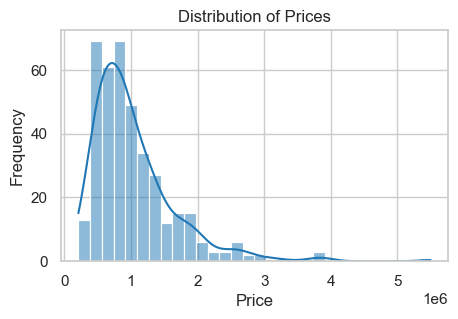

In [48]:
# distribution of Price
plt.figure(figsize=(5, 3))
sns.histplot(house_clean['Price'], bins=30, kde=True)
plt.title('Distribution of Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

#### __Insights:__
As we can see from the graph above, the distribution of house price is heavily right-skewed.  This skewness can potentially affect the performance of a linear regression model. Therefore, we need to apply a log transformation to make it more normally distributed.

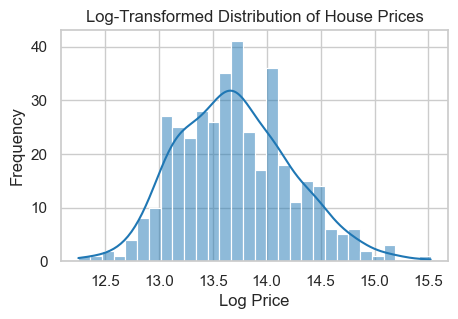

In [49]:
# applying log transformation to 'Price'
house_clean['Price'] = np.log(house_clean['Price'])

# plotting the transformed distribution
plt.figure(figsize=(5, 3))
sns.histplot(house_clean['Price'], bins=30, kde=True)
plt.title('Log-Transformed Distribution of House Prices')
plt.xlabel('Log Price')
plt.ylabel('Frequency')
plt.show()

The prices now appear to be normalized and we can continue on with our model developoment using log price.

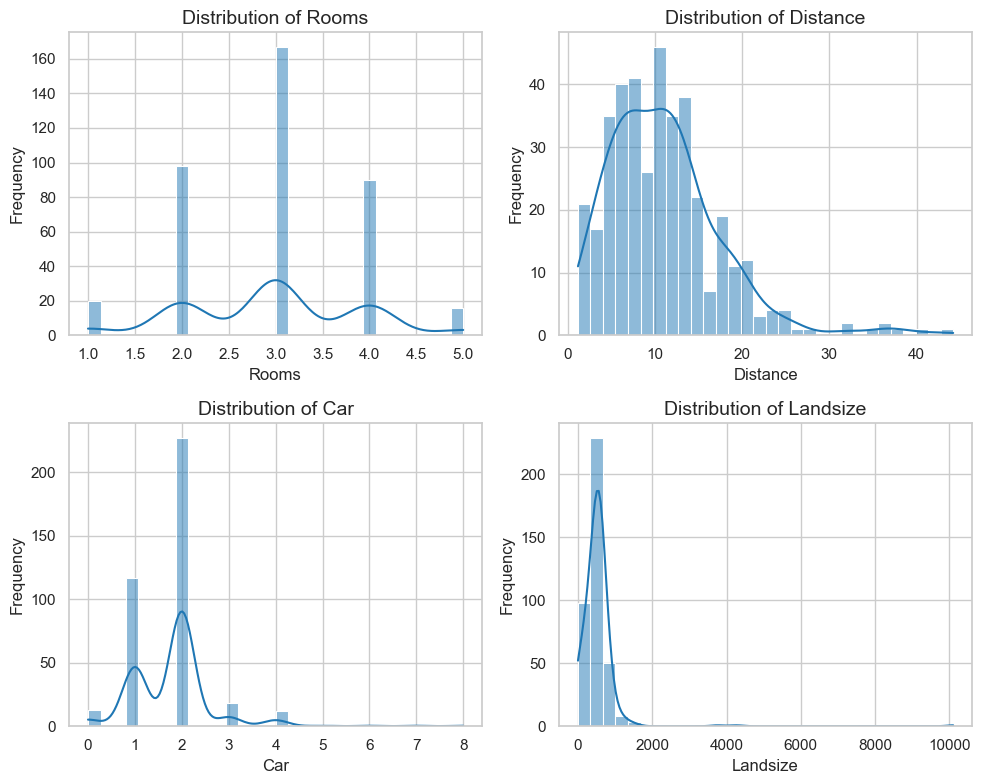

In [50]:
# create histograms to see the distribution of the continuous variables

# set the style & context of the plots
sns.set_style('whitegrid')
sns.set_context('notebook')

# list of columns to plot and create a figure and a set of subplots
hist_columns = ['Rooms', 'Distance', 'Car', 'Landsize']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
# Flatten the axes array for easy iterating
axes = axes.flatten()

# plot histograms
for i, col in enumerate(hist_columns):
    sns.histplot(house_clean[col], ax=axes[i], kde=True, bins=30)
    axes[i].set_title(f'Distribution of {col}', fontsize=14)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

#### __Insights:__  
- __Rooms:__ The majority of properties have between 2 to 4 rooms.  
- __Distance:__ This feature is right-skewed, with most properties 10 miles away from CBD in Kilometres.
- __Car:__ This feature also shows a right-skewed distribution, with most properties having space for 1 or 2 cars.  
- __Landsize:__ The land size distribution is heavily skewed to the right, suggesting that most properties have smaller land sizes, with very few properties having large land areas.   


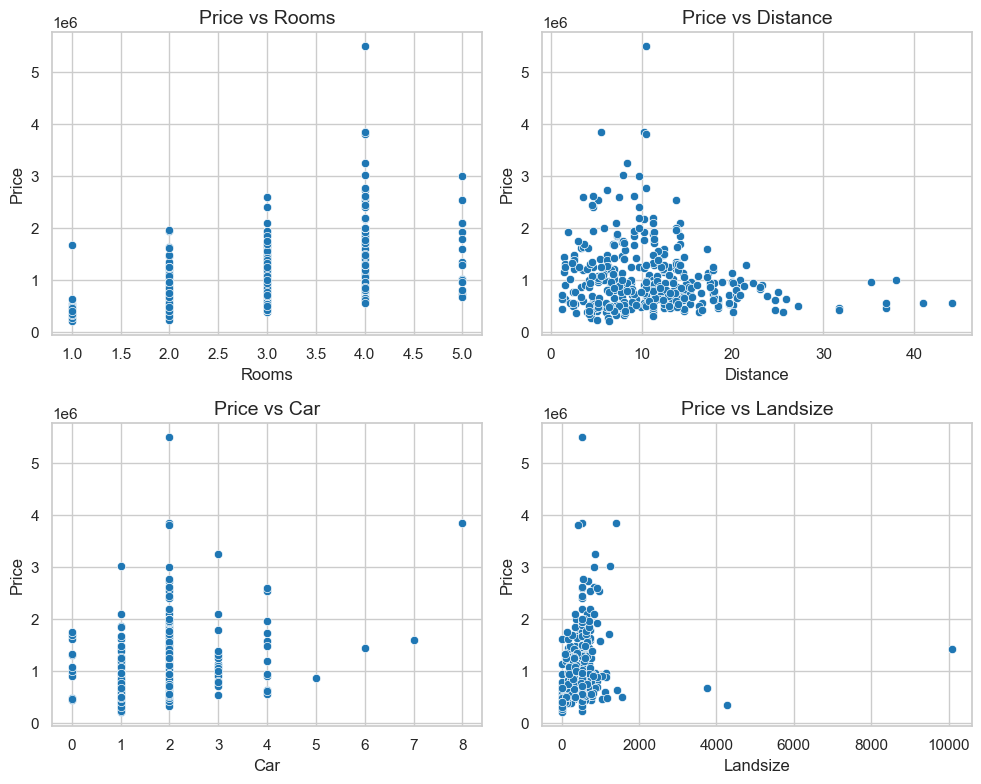

In [51]:
# create scatter plots to explore relationships between key variables

# list of columns to plot and create a figure and a set of subplots
scatter_columns = ['Rooms', 'Distance', 'Car', 'Landsize']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# flatten the axes array for easy iterating
axes = axes.flatten()

# plot scatter plots
for i, col in enumerate(scatter_columns):
    sns.scatterplot(x = house_clean[col], y = house['Price'], ax = axes[i])
    axes[i].set_title(f'Price vs {col}', fontsize=14)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Price')
    
plt.tight_layout()
plt.show()

#### __Insights:__    
- __Price vs Rooms:__ There's a general trend indicating that properties with more rooms tend to have higher prices. However, the relationship is not strictly linear, and there's considerable variation in price at each room level.  
- __Price vs Distance:__ There seems no clear pattern between these two variables, it's clustered, the data may need to be tranformed (log) to show more patterns.    
- __Price vs Car:__ The relationship between the number of car spaces and property prices is unclear as well. While there seems to be a slight positive trend, the variation in prices is substantial across all levels of car spaces.  
- __Price vs Landsize:__ This plot shows a wide dispersion of prices across different land sizes. Although there are properties with large land sizes at various price points, the trend is not strongly defined.  

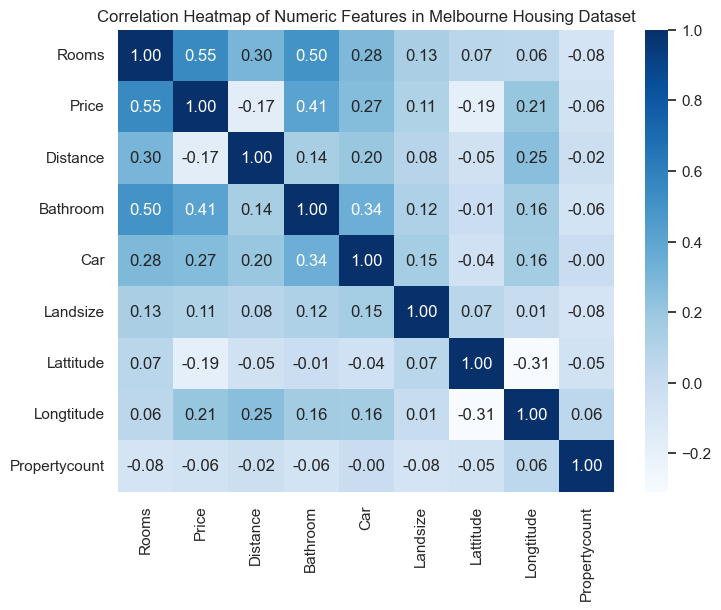

In [52]:
# create heatmap for correlations between all variables 

# select only numeric columns for the correlation matrix
numeric_data = house_clean.select_dtypes(include=[float, int])

# calculate the correlation matrix
correlation_matrix = numeric_data.corr()

# create a heatmap to visualize the correlations
plt.figure(figsize = (8, 6))
sns.heatmap(correlation_matrix, annot = True, fmt = ".2f", cmap = 'Blues')
plt.title("Correlation Heatmap of Numeric Features in Melbourne Housing Dataset")
plt.show()

#### __Insights:__  
- __Price and Rooms:__ There is a positive correlation between Rooms and Price, indicating that the more rooms a property has, the higher price it usually list.
- __Landsize and Car:__ There's a small positive correlation between land size and car spaces. This could indicate that properties with larger land areas are more likely to have more car spaces, which is intuitive as larger properties can typically accommodate more vehicles.  
- __Distance and Price:__ The negative correlation between distance and price suggests that properties closer to the city center tend to be more expensive. This is a common trend in many urban real estate markets.  

---

### __2. Linear Regression Model Development:__

#### __2.1 Encoding categorical variables__

In [53]:
# missing values handled aboves 
# checking data types 
house_clean.dtypes

Rooms              int64
Type              object
Price            float64
Method            object
SellerG           object
Distance         float64
Bathroom         float64
Car              float64
Landsize         float64
CouncilArea       object
Lattitude        float64
Longtitude       float64
Regionname        object
Propertycount      int64
dtype: object

In [54]:
data_dum = pd.get_dummies(house_clean, columns = ["Type",
                                                  "Regionname",
                                                  'SellerG', 
                                                  'Method', 
                                                  'CouncilArea'])
data_dum.dtypes

Rooms                                     int64
Price                                   float64
Distance                                float64
Bathroom                                float64
Car                                     float64
                                         ...   
CouncilArea_Stonnington City Council       bool
CouncilArea_Whitehorse City Council        bool
CouncilArea_Whittlesea City Council        bool
CouncilArea_Wyndham City Council           bool
CouncilArea_Yarra City Council             bool
Length: 139, dtype: object

In [55]:
# convert boolean columns to int64
final_data = data_dum.astype({col: 'int64' for col in data_dum.columns if data_dum[col].dtype == 'bool'})
final_data.dtypes

Rooms                                     int64
Price                                   float64
Distance                                float64
Bathroom                                float64
Car                                     float64
                                         ...   
CouncilArea_Stonnington City Council      int64
CouncilArea_Whitehorse City Council       int64
CouncilArea_Whittlesea City Council       int64
CouncilArea_Wyndham City Council          int64
CouncilArea_Yarra City Council            int64
Length: 139, dtype: object

#### __2.2 Develop a Linear regression model to predict price of house in Melbourne.__

In [56]:
# separate features and target variable
X = final_data.drop('Price', axis=1)
y = final_data['Price']

# adding a constant 
X = sm.add_constant(X)

# split test 20% and train 80%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# build a linear regression model
model_linear = sm.OLS(y_train, X_train).fit()
model_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     7.752
Date:                Wed, 31 Jan 2024   Prob (F-statistic):           3.40e-35
Time:                        22:37:34   Log-Likelihood:                 61.177
No. Observations:                 312   AIC:                             129.6
Df Residuals:                     186   BIC:                             601.3
Df Model:                         125                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                        -57.5229     31.970     -1.799      0.074    -120.593       5.547
Rooms                                          0.1847      0.031      6.045      0.000       0.124       0.245
Distance                                      -0.0404      0.009     -4.710      0.000      -0.057      -0.023
Bathroom                                       0.0449      0.031      1.447      0.150      -0.016       0.106
Car                                            0.0787      0.026      3.047      0.003       0.028       0.130
Landsize                                     4.09e-05   2.84e-05      1.440      0.152   -1.51e-05     9.7e-05
Lattitude                                     -0.4873      0.519     -0.940      0.349      -1.511       0.536
Longtitude                                     0.6442      0.390      1.651      0.100      -0.126       1.414
Propertycount                              -2.058e-06   5.25e-06     -0.392      0.696   -1.24e-05     8.3e-06
Type_h                                       -18.9293     10.657     -1.776      0.077     -39.953       2.095
Type_t                                       -19.1603     10.659     -1.798      0.074     -40.188       1.868
Type_u                                       -19.4334     10.654     -1.824      0.070     -40.452       1.585
Regionname_Eastern Metropolitan               -7.6053      4.336     -1.754      0.081     -16.159       0.948
Regionname_Eastern Victoria                   -7.9278      4.296     -1.846      0.067     -16.402       0.546
Regionname_Northern Metropolitan              -7.8494      4.318     -1.818      0.071     -16.368       0.669
Regionname_Northern Victoria                  -4.4287      2.626     -1.686      0.093      -9.610       0.753
Regionname_South-Eastern Metropolitan         -7.6449      4.344     -1.760      0.080     -16.215       0.925
Regionname_Southern Metropolitan              -7.7363      4.329     -1.787      0.076     -16.277       0.805
Regionname_Western Metropolitan               -7.2603      3.942     -1.842      0.067     -15.038       0.517
Regionname_Western Victoria                   -7.0702      3.823     -1.850      0.066     -14.611       0.471
SellerG_@Realty                               -0.5822      0.506     -1.149      0.252      -1.581       0.417
SellerG_Airport                               -0.9683      0.514     -1.886      0.061      -1.981       0.045
SellerG_Barlow                                -0.5477      0.499     -1.096      0.274      -1.533       0.438
SellerG_Barry                                 -0.7245      0.407     -1.781      0.077      -1.527       0.078
SellerG_Beller                                -0.9876      0.499     -1.979      0.049

In [57]:
# making predictions on the test set
y_pred = model_linear.predict(X_test)


---

### __3. Model Evaluation:__

#### __3.1 Evaluate linear regression model using R^2 / MSE / RMSE / MAE__

In [58]:
# Evaluation metrics
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f'R^2: {r2}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

R^2: 0.5939101871845447
MSE: 0.15539071760051834
RMSE: 0.3941962932353859
MAE: 0.30093467835560544


#### __Interpretations:__
- The __R-squared__ value is 0.594. This indicates that approximately 59.4% of the variation in house prices can be explained by the specified model with the included covariates. It appears to be a moderate fit, but there could still be a problem of overfitting cause the R^2 for the sample data is 0.839, far larger than 0.594.    
- The __MSE__ value is 0.155, the __RMSE__ value is 0.394 and the __MAE__ value is 0.301, all showing a moderate level of prediction error for out of sample predictions using the model.

---

### __4. Regularization:__

#### __4.1 Is there a need for Lasso regularization?__

In [59]:
#comparing test and training results 

#R^2 in sample
y_pred_train = model_linear.predict(X_train)
r2_train = r2_score(y_train, y_pred_train)

#RMSE in sample 
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))

#print results 
print(f"Training R^2:: {r2_train}")
print(f" Training RMSE: {rmse_train}")

Training R^2:: 0.8389689566347215
 Training RMSE: 0.19888711513806237


#### __Answer:__
There is a need for Lasso regularization.

On one hand, the R^2 is 0.839 for training data and 0.594 for testing data and the RMSE is 0.199 for training data and 0.394 for testing data, meaning that the data performs better on training data but little poor on unseen test data, indicating a possible of __overfitting__. Thus, it might benefit from Lasso regularization.  

On the other hand, the smallest eigenvalue for the model is 4.6e-32. This might indicate that there are strong __multicollinearity__ problem. Lasso can select among the correlated features and reduce the coefficients of others to zero to help solving the multicollinearity probelm. 

#### __4.2 Set up a Lasso regression model and fit it to the training data__

In [60]:
# scale matters because of penalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [61]:
# determining the optimal alpha value 
lasso_cv = LassoCV(alphas = np.logspace(-6, 6, 13), cv = 5, random_state = 42, max_iter = 10000)
lasso_cv.fit(X_train, y_train)
optimal_alpha = lasso_cv.alpha_
print("Optimal Alpha:", optimal_alpha)

Optimal Alpha: 0.001


In [62]:
# fitting lasso with the specified penalization term to the training data
model_lasso = Lasso(alpha = 0.001)
model_lasso.fit(X_train_scaled, y_train)

Lasso(alpha=0.001)

#### __4.3 Perform Lasso regression on both training and test data__

In [63]:
# getting the coefficients and intercept
coefficients = model_lasso.coef_
intercept = model_lasso.intercept_

In [64]:
# pair variable names with lasso coefficients 
coefficients = model_lasso.coef_
variable_names = list(final_data.columns)  
features = dict(zip(variable_names, coefficients))
features

{'Rooms': 0.0,
 'Price': 0.1668513857381194,
 'Distance': -0.24405868755570162,
 'Bathroom': 0.03704432571198437,
 'Car': 0.06128865234360175,
 'Landsize': 0.024208021510111317,
 'Lattitude': -0.04323811163528905,
 'Longtitude': 0.05877106468792069,
 'Propertycount': -0.004381815629747358,
 'Type_h': 0.11065109706663441,
 'Type_t': -0.0,
 'Type_u': -0.11490091831511606,
 'Regionname_Eastern Metropolitan': 0.021784989271533692,
 'Regionname_Eastern Victoria': -0.004141107404473196,
 'Regionname_Northern Metropolitan': -0.051093453831725796,
 'Regionname_Northern Victoria': 0.03006687760889247,
 'Regionname_South-Eastern Metropolitan': 0.015081503689058572,
 'Regionname_Southern Metropolitan': 0.0,
 'Regionname_Western Metropolitan': -0.0007748960832595561,
 'Regionname_Western Victoria': 0.006330919845527653,
 'SellerG_@Realty': 0.0054723430982908045,
 'SellerG_Airport': -0.014025691703269323,
 'SellerG_Barlow': 0.006398748154434301,
 'SellerG_Barry': -0.008036735990007947,
 'SellerG_Be

In [65]:
# predicting on training and test data
train_preds = model_lasso.predict(X_train_scaled)
test_preds = model_lasso.predict(X_test_scaled)

# calculating metrics for evaluation
train_r2 = r2_score(y_train, train_preds)
test_r2 = r2_score(y_test, test_preds)
train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))

# preparing the summary
summary = {'Training R^2': train_r2,
           'Test R^2': test_r2,
           'Training RMSE': train_rmse,
           'Test RMSE': test_rmse}
summary

{'Training R^2': 0.8376779262763803,
 'Test R^2': 0.6890802568532377,
 'Training RMSE': 0.19968279000707448,
 'Test RMSE': 0.34492576710177986}

#### __4.4 Analyze and explain how the results change from previous answer__

#### __Answer:__
- __Coefficients:__ Some coefficients became zero in the Lasso model, such as 'Rooms' and 'Type_t', indicating that those features were selected out by the model.  
- __R^2:__ Both models have similar R^2 values on the train set, with the linear model at 0.84 and the Lasso model at approximately 0.84 as well. However, lasso model performs better than linear model on the test set. The R^2 values in testing data is around 0.69 in lasso model and around 0.59 in linear model, confirming that lasso regularization does reduce overfitting.
- __RMSE:__ Both models have similar RMSE on the train set which are around 0.2, however, lasso model performs better than linear model on the test set with a RMSE of 0.345 compared to 0.394.

- __In summary,__ while both models exhibit similar performance metrics in training data, the Lasso model performs significant better on the testing data and also provides a benefit in terms of feature selection and model simplicity.

---

### __5. Out-of-sample performance:__

#### __5.1 Split the data and recreate the models__

In [66]:
X = final_data.drop('Price', axis=1)
y = final_data['Price']
X = sm.add_constant(X)
# split test 20% and train 80%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 43)

In [67]:
# recreate linear regression model
linear = sm.OLS(y_train, X_train).fit()
linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     10.67
Date:                Wed, 31 Jan 2024   Prob (F-statistic):           1.08e-45
Time:                        22:37:35   Log-Likelihood:                 62.829
No. Observations:                 312   AIC:                             110.3
Df Residuals:                     194   BIC:                             552.0
Df Model:                         117                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                        -14.7916     30.261     -0.489      0.626     -74.473      44.890
Rooms                                          0.1972      0.030      6.640      0.000       0.139       0.256
Distance                                      -0.0514      0.008     -6.770      0.000      -0.066      -0.036
Bathroom                                       0.0892      0.029      3.124      0.002       0.033       0.146
Car                                            0.0439      0.022      1.995      0.047       0.000       0.087
Landsize                                    4.486e-05   2.81e-05      1.598      0.112   -1.05e-05       0.000
Lattitude                                      0.4330      0.546      0.794      0.428      -0.643       1.509
Longtitude                                     0.3814      0.374      1.021      0.309      -0.356       1.119
Propertycount                              -1.998e-06   4.96e-06     -0.403      0.688   -1.18e-05    7.79e-06
Type_h                                        -4.6715     10.088     -0.463      0.644     -24.568      15.225
Type_t                                        -4.8608     10.089     -0.482      0.631     -24.759      15.038
Type_u                                        -5.2593     10.083     -0.522      0.603     -25.147      14.628
Regionname_Eastern Metropolitan               -1.8925      4.189     -0.452      0.652     -10.155       6.370
Regionname_Eastern Victoria                   -1.6789      3.594     -0.467      0.641      -8.767       5.409
Regionname_Northern Metropolitan              -2.2260      4.173     -0.533      0.594     -10.457       6.004
Regionname_Northern Victoria                  -0.9384      2.499     -0.375      0.708      -5.868       3.991
Regionname_South-Eastern Metropolitan         -2.0848      4.196     -0.497      0.620     -10.360       6.190
Regionname_Southern Metropolitan              -2.0228      4.183     -0.484      0.629     -10.273       6.227
Regionname_Western Metropolitan               -2.1974      3.760     -0.584      0.560      -9.612       5.217
Regionname_Western Victoria                   -1.7507      3.696     -0.474      0.636      -9.040       5.539
SellerG_@Realty                               -0.2764      0.539     -0.513      0.609      -1.339       0.786
SellerG_Airport                               -0.3136      0.507     -0.619      0.537      -1.313       0.686
SellerG_Barlow                                 0.1359      0.490      0.277      0.782      -0.831       1.103
SellerG_Barry                                 -0.2108      0.402     -0.525      0.600      -1.003       0.582
SellerG_Beller                              7.893e-14   1.62e-13      0.488      0.626

In [68]:
# scale matters because of penalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# determining the optimal alpha value 
lasso_cv = LassoCV(alphas = np.logspace(-6, 6, 13), cv = 5, random_state = 43, max_iter = 10000)
lasso_cv.fit(X_train_scaled, y_train)
optimal_alpha = lasso_cv.alpha_

# recreate the lasso regression model
lasso = Lasso(alpha = optimal_alpha)
lasso.fit(X_train_scaled, y_train)

Lasso(alpha=0.01)

#### __5.2 Estimate AIC, AICc, BIC for both models using the training data__

In [79]:
# In-sample prediction with linear model
y_pred = linear.predict(X_train) 

n_user = X_train.shape[0]  # Number of observations
k_user =X_train.shape[1]+1

# Calculate RSS using the correct data
rss = mean_squared_error(y_train, y_pred) * n_user

# Calculate the log-likelihood approximation
log_likelihood = -n_user / 2 * np.log(2 * np.pi * rss / n_user) - rss / (2 * rss / n_user)

# Compute AIC using the correct log-likelihood
aic = 2 * k_user - 2 * log_likelihood

# Compute AICc using the correct formula
aicc = aic + (2 * k_user * (k_user + 1)) / (n_user - k_user - 1)

# Compute BIC using the correct formula
bic = np.log(n_user) * k_user - 2 * log_likelihood

# Print the result
print(f'AIC_linear: {aic}')
print(f'AICc_linear: {aicc}')
print(f'BIC_linear: {bic}')

AIC_linear: 154.34223980681304
AICc_linear: 385.21943278926915
BIC_linear: 678.3626861001405


In [78]:
# In-sample prediction with lasso model
y_pred = lasso.predict(X_train_scaled) 

n_user = X_train_scaled.shape[0]  # Number of observations
k_user =X_train_scaled.shape[1]+1

# Calculate RSS using the correct data
rss = mean_squared_error(y_train, y_pred) * n_user

# Calculate the log-likelihood approximation
log_likelihood = -n_user / 2 * np.log(2 * np.pi * rss / n_user) - rss / (2 * rss / n_user)

# Compute AIC using the correct log-likelihood
aic = 2 * k_user - 2 * log_likelihood

# Compute AICc using the correct formula
aicc = aic + (2 * k_user * (k_user + 1)) / (n_user - k_user - 1)

# Compute BIC using the correct formula
bic = np.log(n_user) * k_user - 2 * log_likelihood

# Print the result
print(f'AIC_lasso: {aic}')
print(f'AICc_lasso: {aicc}')
print(f'BIC_lasso: {bic}')

AIC_lasso: 234.55825683427048
AICc_lasso: 465.43544981672665
BIC_lasso: 758.5787031275979


#### __5.3 Estimate 5-fold CV for both models using the training data__

In [72]:
# 5-fold cv for linear model
kf = KFold(n_splits = 5, shuffle = True, random_state= 1)
linear_MSE = cross_val_score(LinearRegression(), X_train, y_train, cv = kf, scoring = make_scorer(mean_squared_error))
linear_MSE = np.mean(linear_MSE)
linear_RMSE = np.sqrt(linear_MSE)
print(f'Root Mean Squared Error Linear Regression model using training data is {linear_RMSE}.')

Root Mean Squared Error Linear Regression model using training data is 0.3425853135776761.


In [73]:
# 5-fold cv for lasso model
kf = KFold(n_splits = 5, shuffle = True, random_state = 1)
lasso_MSE = cross_val_score(lasso, X_train_scaled, y_train, cv = kf, scoring = make_scorer(mean_squared_error))
lasso_MSE = np.mean(lasso_MSE)
lasso_RMSE = np.sqrt(lasso_MSE)
print(f'Root Mean Squared Error for Lasso Regression model using training data is {lasso_RMSE}.')

Root Mean Squared Error for Lasso Regression model using training data is 0.28073417168678333.



#### __5.4 Estimate the models true OOS performance by computing their deviance on the test data__

In [74]:
# estimate OOS performance for linear regression model

y_pred_train = linear.predict(X_train)
r2_linear_train = r2_score(y_train, y_pred_train)
mse_linear_train = mean_squared_error(y_train, y_pred_train)
rmse_linear_train = np.sqrt(mse_linear_train)

y_pred_test = linear.predict(X_test)
r2_linear_test = r2_score(y_test, y_pred_test)
mse_linear_test = mean_squared_error(y_test, y_pred_test)
rmse_linear_test = np.sqrt(mse_linear_test)

print(f'R^2 train Linear regression {r2_linear_train}.')
print(f'RMSE train Linear regression {rmse_linear_train}.','\n')  
print(f'R^2 test Linear regression {r2_linear_test}.')
print(f'RMSE test Linear regression {rmse_linear_test}.','\n')

R^2 train Linear regression 0.8654983089865937.
RMSE train Linear regression 0.19783673702608773. 

R^2 test Linear regression 0.31936956855456056.
RMSE test Linear regression 0.3661982850759536. 



In [75]:
# estimate OOS performance for lasso regression model

y_pred_train = lasso.predict(X_train_scaled)
r2_lasso_train = r2_score(y_train, y_pred_train)
mse_lasso_train = mean_squared_error(y_train, y_pred_train)
rmse_lasso_train = np.sqrt(mse_lasso_train)

y_pred_test = lasso.predict(X_test_scaled)
r2_lasso_test = r2_score(y_test, y_pred_test)
mse_lasso_test = mean_squared_error(y_test, y_pred_test)
rmse_lasso_test = np.sqrt(mse_lasso_test)

print(f'R^2 train Lasso regression {r2_lasso_train}.')
print(f'RMSE train Lasso regression {rmse_lasso_train}.','\n')  
print(f'R^2 test Lasso regression {r2_lasso_test}.')
print(f'RMSE test Lasso regression {rmse_lasso_test}.','\n')

R^2 train Lasso regression 0.8260653958709182.
RMSE train Lasso regression 0.22497593466105517. 

R^2 test Lasso regression 0.5248916620286983.
RMSE test Lasso regression 0.3059545744177249. 



#### __5.5 Estimate AIC, AICc, BIC for both models using the testing data__

In [80]:
# Out-of-sample prediction with linear model
y_pred = linear.predict(X_test) 

n_user = X_test.shape[0]  # Number of observations
k_user =X_test.shape[1]+1

# Calculate RSS using the correct data
rss = mean_squared_error(y_test, y_pred) * n_user

# Calculate the log-likelihood approximation
log_likelihood = -n_user / 2 * np.log(2 * np.pi * rss / n_user) - rss / (2 * rss / n_user)

# Compute AIC using the correct log-likelihood
aic = 2 * k_user - 2 * log_likelihood

# Compute AICc using the correct formula
aicc = aic + (2 * k_user * (k_user + 1)) / (n_user - k_user - 1)

# Compute BIC using the correct formula
bic = np.log(n_user) * k_user - 2 * log_likelihood

# Print the result
print(f'AIC_linear: {aic}')
print(f'AICc_linear: {aicc}')
print(f'BIC_linear: {bic}')

AIC_linear: 345.46859614133723
AICc_linear: -291.30559740704985
BIC_linear: 677.1912954867203


In [81]:
# Out-of-sample prediction with lasso model
y_pred = lasso.predict(X_test_scaled) 

n_user = X_test_scaled.shape[0]  # Number of observations
k_user =X_test_scaled.shape[1]+1

# Calculate RSS using the correct data
rss = mean_squared_error(y_test, y_pred) * n_user

# Calculate the log-likelihood approximation
log_likelihood = -n_user / 2 * np.log(2 * np.pi * rss / n_user) - rss / (2 * rss / n_user)

# Compute AIC using the correct log-likelihood
aic = 2 * k_user - 2 * log_likelihood

# Compute AICc using the correct formula
aicc = aic + (2 * k_user * (k_user + 1)) / (n_user - k_user - 1)

# Compute BIC using the correct formula
bic = np.log(n_user) * k_user - 2 * log_likelihood

# Print the result
print(f'AIC_lasso: {aic}')
print(f'AICc_lasso: {aicc}')
print(f'BIC_lasso: {bic}')

AIC_lasso: 317.06994349530476
AICc_lasso: -319.7042500530823
BIC_lasso: 648.7926428406878


#### __Insights and Summary:__  

- __Deviances Comparison:__   
-- R² for Linear model on train data: 0.865  
-- RMSE for Linear model on train data: 0.198   
-- R² for Linear model on test data: __0.319__    
-- RMSE for Linear model on test data: 0.366  
~~ R² for Lasso model on train data: 0.826    
~~ RMSE for Lasso model on train data: 0.225  
~~ R² for Lasso model on test data: __0.525__    
~~ RMSE for Lasso model on test data: 0.306    
As we can see from the evaluation above, the most significant difference occurs in the R² for both model on test data, indicating that lasso regression model reduce the overfitting phenomenon. 

--
- __Which IC is most similar to the models’ true OOS performance?__  
Linear model on train data:  
-- AIC_linear: 154.34   
-- AICc_linear: 385.22   
-- __BIC_linear: 678.36__    
Linear model on test data:   
-- AIC_linear: 345.47   
-- AICc_linear: -291.31    
-- __BIC_linear: 677.19__   
For linear regression model, BIC is most stable in training data and testing data. (most similar to the models’ true OOS performance)   
Lasso model on train data:   
~~ __AIC_lasso: 234.56__   
~~ AICc_lasso: 465.44   
~~ BIC_lasso: 758.58   
Lasso model on test data:   
~~ __AIC_lasso: 317.07__   
~~ AICc_lasso: -319.70    
~~ BIC_lasso: 648.79  
For lasso regression model, AIC is most stable in training data and testing data. (most similar to the models’ true OOS performance)   

--
- __Comparison in 5-fold CV__   
-- RMSE for Linear model on train data: 0.343  
-- RMSE for Linear model on test data: 0.366  
~~ RMSE for Lasso model on train data is 0.281   
~~ RMSE for Lasso model on test data: 0.306  

